In [3]:
# check which machine we're running on
import socket
machine = socket.gethostname()

suplabels_all = ['Rho_Bmag', 'Mdot_MRIstability', 'Mdot_beta', 'alpha_RvsM'] # all possible plot options
suplabels = [] # which plots to generate

# if not running interactively, read arguments from the command line
import sys
suplabels = []
if machine == 'ppjanka-razer' or len(sys.argv) < 2:
    supfolder = 'M5'
else:
    supfolder = sys.argv[1]
    i = 2
    while i < len(sys.argv):
        if sys.argv[i] == '-navg':
            frames_to_avg = sys.argv[i+1]
            i += 2
        elif sys.argv[i] in suplabels_all:
            suplabels.append(sys.argv[i])
            i += 1

# plot everything unless specified otherwise
if len(suplabels) == 0:
    suplabels = suplabels_all

In [4]:
import numpy as np

exec(open("./diagnostics_header.py").read())
mach_no = float(supfolder.split('_')[0][1:])

# disk size
theta_H = 1./mach_no
disk_x1max = 0.25
disk_x2min = 0.5*np.pi - 4.*theta_H
disk_x2max = 0.5*np.pi + 4.*theta_H

import diagnostics_ops as diops
import diagnostics_vars as divars
import diagnostics_vis as divis

5.0


In [3]:
# depending on the machine, set up number of threads and location of the data
if machine[:7] == 'perseus':
    machine = 'PERSEUS'
    nproc = 16
    data_pathstem = '/home/ppjanka/tigress_pp/THESIS/%s/' % supfolder
elif machine[:11] == 'tigressdata':
    machine = 'TIGRESSDATA'
    nproc = 4
    data_pathstem = '/home/ppjanka/tigress_pp/THESIS/%s/' % supfolder
elif machine == 'ppjanka-razer':
    machine = 'RAZER'
    nproc = 2
    data_pathstem = '/DATA/Dropbox/LOOTRPV/Princeton_PhD/Thesis/globAccDisk/athena/bin-mhd/M5_noInfl/'
    
print('Running on %s. Nproc = %i.' % (machine, nproc))

rmax_plot = 0.25

redo = False # if true, all png's will be recreated from scratch
testing = False # testing mode

# where within data_pathstem are the .athdf files stored
data_folders = ['R4', 'R5']
temp_pathstem = data_pathstem

frame = {} # dictionary for frame functions
frame_setup = {} # dictionary for frame setup functions (kwargs)

# ----------
import glob
if nproc > 1:
    from multiprocessing import Pool

# find all athdf files to process
athdf_files = []
for data_folder in data_folders:
    athdf_files += glob.glob(data_pathstem + data_folder + '/*out2*.athdf')
athdf_files = sorted(athdf_files)

# ---------
# null frame setup
non_vminmax = {'poloidal_profile': None, 'poloidal_slice': None, 'equatorial_slice': None, 'theta_profile': None, 'radial_profile': None}

all_colorbars = True
left_vmin = non_vminmax
left_vmax = non_vminmax
right_vmin = non_vminmax
right_vmax = non_vminmax
left_label = ''
right_label = ''
vars_obj_left = divars.Vars()
vars_obj_right = divars.Vars()
tempdir = ''

Running on RAZER. Nproc = 2.


In [4]:
# these functions handle a temporary folder where plot frames are stored as .png files before turning them into a movie
def name_temp (tag, temp_pathstem=temp_pathstem):
    return temp_pathstem + 'temp_' + tag
def prep_temp (tag, temp_pathstem=temp_pathstem):
    import glob
    import os
    import subprocess
    # create a temporary folder to store the frames
    print('Creating a temporary folder for frame storage: ', end='')
    tempdir = name_temp(tag, temp_pathstem)
    try:
        if os.path.isdir(tempdir):
            if redo and len(glob.glob(tempdir + '/*.png')) > 0:
                subprocess.check_call(['rm', tempdir + '/*.png'])
        else:
            subprocess.check_call(['mkdir', tempdir])
    except subprocess.CalledProcessError as err:
        print('Return code {0} from command \'{1}\''.format(err.returncode, ' '.join(err.cmd)))
    print('done.', flush=True)
    return tempdir
def clean_temp (tempdir):
    import subprocess
    # delete the temporary folder
    print('Deleting the temporary folder: ', end='')
    try:
        subprocess.check_call(['rm', '-r', tempdir])
    except subprocess.CalledProcessError as err:
        print('Return code {0} from command \'{1}\''.format(err.returncode, ' '.join(err.cmd)))
    print('done.', flush=True)

The following cells define possible plots, no processing will be done unless testing == True. If testing == True, a single plot of each will be produced to test the layout.

In [ ]:
# RHO -- B_MAGNITUDE

suplabel = 'Rho_Bmag'

def frame_setup_Rho_Bmag ():
    all_colorbars = False
    left_vmin = {'poloidal_profile': 1.0e-3, 'poloidal_slice': 1.0e-3, 'equatorial_slice': 1.0e-3, 'theta_profile': 1.0e-3, 'radial_profile': 1.0e-3}
    left_vmax = {'poloidal_profile': 1.0e2, 'poloidal_slice': 1.0e2, 'equatorial_slice': 1.0e2, 'theta_profile': 1.0e2, 'radial_profile': 1.0e2}
    right_vmin = {'poloidal_profile': 1.0e-3, 'poloidal_slice': 1.0e-3, 'equatorial_slice': 1.0e-3, 'theta_profile': None, 'radial_profile': None}
    right_vmax = {'poloidal_profile': 10., 'poloidal_slice': 10., 'equatorial_slice': 10., 'theta_profile': None, 'radial_profile': None}
    left_label = 'rho'
    right_label = 'Bmag'
    vars_obj_left = divars.Default('rho')
    vars_obj_right = divars.Bfield()
    tempdir = name_temp(suplabel)
    globals().update(locals()) # broadcast variables to global scope
    
frame_setup[suplabel] = frame_setup_Rho_Bmag

#------------------------------------

def frame_Rho_Bmag (i):
    
    athdf_file = athdf_files[i]
    athdf_file_left = athdf_file
    athdf_file_right = athdf_file
    
    frame_setup_Rho_Bmag()
    outfile = tempdir + '/%05d.png' % i
    
    # if file exists, only redo the 1D profiles if necessary
    import os.path
    if not redo and os.path.isfile(outfile):
        
        if not os.path.isfile(data_pathstem + suplabel + '_profiles1D.pkl'):
            print(' - generating 1D profiles only for %s.. ' % athdf_file.split('/')[-1])
            buffer = {}
            time, buffer = divis.get_1D_profiles(athdf_file=athdf_file_left, \
                vars_obj=vars_obj_left, label=left_label, \
                outputs=buffer, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
            time, buffer = divis.get_1D_profiles(athdf_file=athdf_file_right, \
                vars_obj=vars_obj_right, label=right_label, \
                outputs=buffer, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
            return time, buffer
        else:        
            return
    
    print(' - plotting %s.. ' % athdf_file.split('/')[-1])
    
    import matplotlib
    if machine != 'RAZER':
        matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import numpy as np
    
    old = np.seterr(invalid='ignore') # ignore invalid values in log
    old = np.seterr(divide='ignore') # ignore divide by 0 in log
    
    fig = plt.figure(figsize=(25,15))
    gs = gridspec.GridSpec(4, 6, height_ratios=[0.5,0.25,0.225,0.025], width_ratios=[0.01,0.24,0.25,0.25,0.24,0.01], wspace=0.15)
    scalar_mappables = [plt.cm.ScalarMappable(), plt.cm.ScalarMappable(), plt.cm.ScalarMappable(), plt.cm.ScalarMappable()]

    time, buffer = divis.process_figure(fig=fig, gs=gs, \
                   athdf_file_left=athdf_file_left, \
                   athdf_file_right=athdf_file_right, \
                   vars_obj_left=vars_obj_left, \
                   vars_obj_right=vars_obj_right, \
                   left_vmin=left_vmin, left_vmax=left_vmax, \
                   right_vmin=right_vmin, right_vmax=right_vmax, \
                   left_label=left_label, right_label=right_label, \
                   scalar_mappables=scalar_mappables, \
                   all_colorbars=all_colorbars, \
                   left_rmax=rmax_plot, right_rmax=rmax_plot, \
                   return_1D_profiles=True, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
    
    if testing: # testing
        plt.show(fig)
    else:
        fig.savefig(outfile, format='png')
    del fig, gs
    for sm in scalar_mappables:
        del sm
    plt.close()
    
    return time, buffer

frame[suplabel] = frame_Rho_Bmag

if testing:
    #frame(1)
    frame[suplabel](len(athdf_files)-6)

 - plotting mhdLoops_strat.out2.00513.athdf.. 


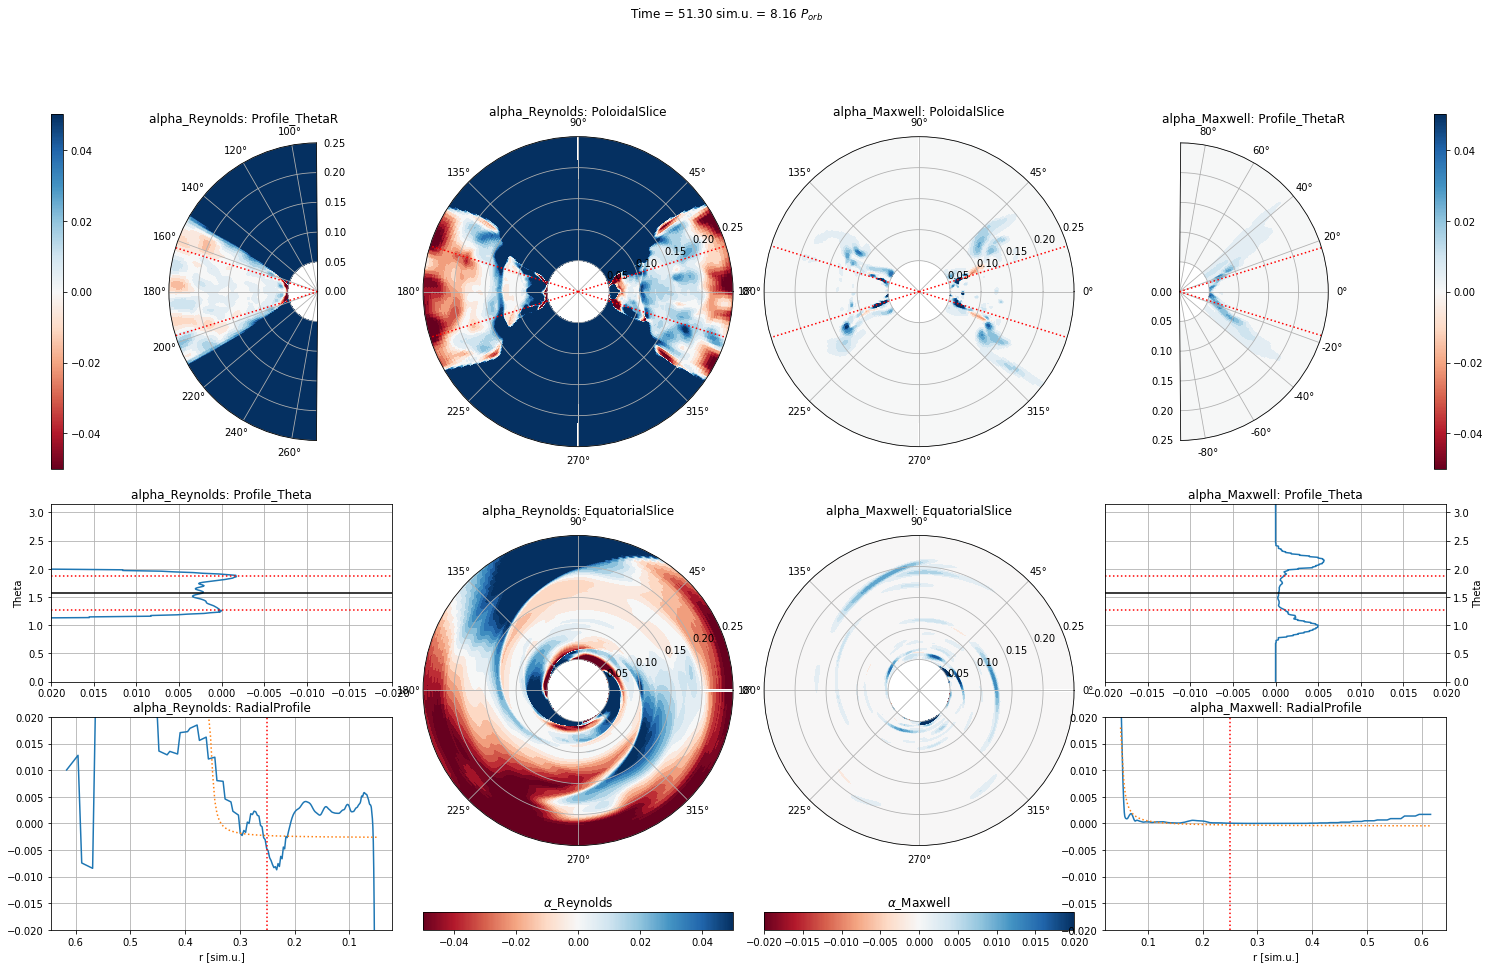

In [6]:
# Alphas: Reynolds vs Maxwell, frame-averaging

suplabel = 'alpha_RvsM'

def frame_setup_alpha_RvsM():
    all_colorbars = False
    alpha_max = 0.5
    left_vmin = {'poloidal_profile': -alpha_max, 'poloidal_slice': -alpha_max, 'equatorial_slice': -alpha_max, 'theta_profile': -0.01, 'radial_profile': -0.1}
    left_vmax = {'poloidal_profile': alpha_max, 'poloidal_slice': alpha_max, 'equatorial_slice': alpha_max, 'theta_profile': 0.5, 'radial_profile': 0.1}
    right_vmin = {'poloidal_profile': -alpha_max, 'poloidal_slice': -alpha_max, 'equatorial_slice': -alpha_max, 'theta_profile': -0.01, 'radial_profile': -0.01}
    right_vmax = {'poloidal_profile': alpha_max, 'poloidal_slice': alpha_max, 'equatorial_slice': alpha_max, 'theta_profile': 0.5, 'radial_profile': 0.1}
    left_label = '$\\alpha$_Reynolds'
    right_label = '$\\alpha$_Maxwell'
    vars_obj_left = divars.AlphaReynolds()
    vars_obj_right = divars.AlphaMaxwell()
    #------------------------------------
    tempdir = name_temp(suplabel)
    globals().update(locals()) # broadcast variables to global scope
    
frame_setup[suplabel] = frame_setup_alpha_RvsM

def frame_alpha_RvsM (i):
    if i > len(athdf_files) - frames_to_avg: return
    
    athdf_file = athdf_files[i:(i+frames_to_avg)]
    athdf_file_left = athdf_file
    athdf_file_right = athdf_file
    
    frame_setup_alpha_RvsM()
    outfile = tempdir + '/%05d.png' % i
    
    # abort if file exists
    import os.path
    if not redo and os.path.isfile(outfile):
        
        if not os.path.isfile(data_pathstem + suplabel + '_profiles1D.pkl'):
            print(' - generating 1D profiles only for %s.. ' % athdf_file[0].split('/')[-1])
            buffer = {}
            time, buffer = divis.get_1D_profiles(athdf_file=athdf_file_left, \
                vars_obj=vars_obj_left, label=left_label, \
                outputs=buffer, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
            time, buffer = divis.get_1D_profiles(athdf_file=athdf_file_right, \
                vars_obj=vars_obj_right, label=right_label, \
                outputs=buffer, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
            return time, buffer
        else:        
            return
    
    print(' - plotting %s.. ' % athdf_file[0].split('/')[-1])
    
    import matplotlib
    if machine != 'RAZER':
        matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import numpy as np
    
    old = np.seterr(invalid='ignore') # ignore invalid values in log
    old = np.seterr(divide='ignore') # ignore divide by 0 in log
    
    fig = plt.figure(figsize=(25,15))
    gs = gridspec.GridSpec(4, 6, height_ratios=[0.5,0.25,0.225,0.025], width_ratios=[0.01,0.24,0.25,0.25,0.24,0.01], wspace=0.15)
    scalar_mappables = [plt.cm.ScalarMappable(cmap='RdBu'), plt.cm.ScalarMappable(cmap='RdBu'), plt.cm.ScalarMappable(cmap='RdBu'), plt.cm.ScalarMappable(cmap='RdBu')]

    time, buffer = divis.process_figure(fig=fig, gs=gs, \
                   athdf_file_left=athdf_file_left, \
                   athdf_file_right=athdf_file_right, \
                   vars_obj_left=vars_obj_left, \
                   vars_obj_right=vars_obj_right, \
                   left_vmin=left_vmin, left_vmax=left_vmax, \
                   right_vmin=right_vmin, right_vmax=right_vmax, \
                   left_label=left_label, right_label=right_label, \
                   left_log_scale=False, right_log_scale=False, \
                   scalar_mappables=scalar_mappables, \
                   left_cmap='RdBu', right_cmap='RdBu', \
                   all_colorbars=all_colorbars, \
                   left_rprofile_fit=True, right_rprofile_fit=True, \
                   left_rmax=rmax_plot, right_rmax=rmax_plot, \
                   return_1D_profiles=True, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
    
    if testing: # testing
        plt.show(fig)
    else:
        fig.savefig(outfile, format='png')
    del fig, gs
    for sm in scalar_mappables:
        del sm
    plt.close()
    
    return time, buffer
    
frame[suplabel] = frame_alpha_RvsM

if testing:
    #frame(1)
    frame[suplabel](len(athdf_files)-6)

In [ ]:
# Mdot vs PlasmaBeta

suplabel = 'Mdot_beta'

def frame_setup_Mdot_beta():
    all_colorbars = False
    left_vmin = {'poloidal_profile': -1.0e-4, 'poloidal_slice': -1.0e-6, 'equatorial_slice': -1.0e-6, 'theta_profile': -0.001, 'radial_profile': -0.0003}
    left_vmax = {'poloidal_profile': 1.0e-4, 'poloidal_slice': 1.0e-6, 'equatorial_slice': 1.0e-6, 'theta_profile': 0.005, 'radial_profile': 0.001}
    right_vmin = {'poloidal_profile': 0.1, 'poloidal_slice': 0.1, 'equatorial_slice': 0.1, 'theta_profile': None, 'radial_profile': None}
    right_vmax = {'poloidal_profile': 1.0e4, 'poloidal_slice': 1.0e4, 'equatorial_slice': 1.0e4, 'theta_profile': None, 'radial_profile': None}
    left_label = 'Mdot'
    right_label = 'PlasmaBeta'
    vars_obj_left = divars.Mdot()
    vars_obj_right = divars.PlasmaBeta()
    #------------------------------------
    tempdir = name_temp(suplabel)
    globals().update(locals()) # broadcast variables to global scope
    
frame_setup[suplabel] = frame_setup_Mdot_beta

def frame_Mdot_beta (i):
    
    athdf_file = athdf_files[i]
    athdf_file_right = athdf_file
    if i < len(athdf_files) - frames_to_avg:
        athdf_file_left = athdf_files[i:(i+frames_to_avg)]
    else:
        athdf_file_left = athdf_files[-frames_to_avg:]
        
    frame_setup_Mdot_beta()
    outfile = tempdir + '/%05d.png' % i
    
    # abort if file exists
    import os.path
    if not redo and os.path.isfile(outfile):
        
        if not os.path.isfile(data_pathstem + suplabel + '_profiles1D.pkl'):
            print(' - generating 1D profiles only for %s.. ' % athdf_file.split('/')[-1])
            buffer = {}
            time, buffer = divis.get_1D_profiles(athdf_file=athdf_file_left, \
                vars_obj=vars_obj_left, label=left_label, \
                outputs=buffer, suptype='sum', \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
            time, buffer = divis.get_1D_profiles(athdf_file=athdf_file_right, \
                vars_obj=vars_obj_right, label=right_label, \
                outputs=buffer, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
            return time, buffer
        else:        
            return
        
    print(' - plotting %s.. ' % athdf_file_right.split('/')[-1])
    
    import matplotlib
    if machine != 'RAZER':
        matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import numpy as np
    
    old = np.seterr(invalid='ignore') # ignore invalid values in log
    old = np.seterr(divide='ignore') # ignore divide by 0 in log
    
    fig = plt.figure(figsize=(25,15))
    gs = gridspec.GridSpec(4, 6, height_ratios=[0.5,0.25,0.225,0.025], width_ratios=[0.01,0.24,0.25,0.25,0.24,0.01], wspace=0.15)
    scalar_mappables = [plt.cm.ScalarMappable(), plt.cm.ScalarMappable(), plt.cm.ScalarMappable(), plt.cm.ScalarMappable()]

    time, buffer = divis.process_figure(fig=fig, gs=gs, \
                   athdf_file_left=athdf_file_left, \
                   athdf_file_right=athdf_file_right, \
                   vars_obj_left=vars_obj_left, \
                   vars_obj_right=vars_obj_right, \
                   left_vmin=left_vmin, left_vmax=left_vmax, \
                   right_vmin=right_vmin, right_vmax=right_vmax, \
                   left_label=left_label, right_label=right_label, \
                   left_log_scale=False, right_log_scale=True, \
                   left_suptype='sum', \
                   scalar_mappables=scalar_mappables, \
                   all_colorbars=all_colorbars, \
                   left_rmax=rmax_plot, right_rmax=rmax_plot, \
                   left_rprofile_fit=True, \
                   left_cbar_format='%.0e', \
                   return_1D_profiles=True, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
    
    if testing: # testing
        plt.show(fig)
    else:
        fig.savefig(outfile, format='png')
    del fig, gs
    for sm in scalar_mappables:
        del sm
    plt.close()
    
    return time, buffer
    
frame[suplabel] = frame_Mdot_beta

if testing:
    #frame(1)
    frame[suplabel](len(athdf_files)-6)

In [ ]:
# Mdot vs MRIstability

suplabel = 'Mdot_MRIstability'

def frame_setup_Mdot_MRIstability():
    all_colorbars = False
    left_vmin = {'poloidal_profile': -1.0e-4, 'poloidal_slice': -1.0e-6, 'equatorial_slice': -1.0e-6, 'theta_profile': -0.001, 'radial_profile': -0.0003}
    left_vmax = {'poloidal_profile': 1.0e-4, 'poloidal_slice': 1.0e-6, 'equatorial_slice': 1.0e-6, 'theta_profile': 0.005, 'radial_profile': 0.001}
    right_vmin = {'poloidal_profile': 1.0e-3, 'poloidal_slice': 1.0e-2, 'equatorial_slice': 1.0e-2, 'theta_profile': None, 'radial_profile': None}
    right_vmax = {'poloidal_profile': 1.0e3, 'poloidal_slice': 1.0e2, 'equatorial_slice': 1.0e2, 'theta_profile': None, 'radial_profile': None}
    left_label = 'Mdot'
    right_label = '$H_{th}/\\lambda_{MRI,min},2\\pi/\\omega_{MRI,max}$'
    vars_obj_left = divars.Mdot()
    vars_obj_right = divars.MRIstability()
    #------------------------------------
    tempdir = name_temp(suplabel)
    globals().update(locals()) # broadcast variables to global scope
    
frame_setup[suplabel] = frame_setup_Mdot_MRIstability

def frame_Mdot_MRIstability (i):
    
    athdf_file = athdf_files[i]
    athdf_file_right = athdf_file
    if i < len(athdf_files) - frames_to_avg:
        athdf_file_left = athdf_files[i:(i+frames_to_avg)]
    else:
        athdf_file_left = athdf_files[-frames_to_avg:]
        
    frame_setup_Mdot_MRIstability()
    outfile = tempdir + '/%05d.png' % i
    
    # abort if file exists
    import os.path
    if not redo and os.path.isfile(outfile):
        
        if not os.path.isfile(data_pathstem + suplabel + '_profiles1D.pkl'):
            print(' - generating 1D profiles only for %s.. ' % athdf_file.split('/')[-1])
            buffer = {}
            time, buffer = divis.get_1D_profiles(athdf_file=athdf_file_left, \
                vars_obj=vars_obj_left, label=left_label, \
                outputs=buffer, suptype='sum', \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
            time, buffer = divis.get_1D_profiles(athdf_file=athdf_file_right, \
                vars_obj=vars_obj_right, label=right_label, \
                outputs=buffer, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
            return time, buffer
        else:        
            return
        
    print(' - plotting %s.. ' % athdf_file_right.split('/')[-1])
    
    import matplotlib
    if machine != 'RAZER':
        matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import numpy as np
    
    old = np.seterr(invalid='ignore') # ignore invalid values in log
    old = np.seterr(divide='ignore') # ignore divide by 0 in log
    
    fig = plt.figure(figsize=(25,15))
    gs = gridspec.GridSpec(4, 6, height_ratios=[0.5,0.25,0.225,0.025], width_ratios=[0.01,0.24,0.25,0.25,0.24,0.01], wspace=0.15)
    scalar_mappables = [plt.cm.ScalarMappable(), plt.cm.ScalarMappable(), plt.cm.ScalarMappable(), plt.cm.ScalarMappable()]

    time, buffer = divis.process_figure(fig=fig, gs=gs, \
                   athdf_file_left=athdf_file_left, \
                   athdf_file_right=athdf_file_right, \
                   vars_obj_left=vars_obj_left, \
                   vars_obj_right=vars_obj_right, \
                   left_vmin=left_vmin, left_vmax=left_vmax, \
                   right_vmin=right_vmin, right_vmax=right_vmax, \
                   left_label=left_label, right_label=right_label, \
                   left_log_scale=False, right_log_scale=True, \
                   left_suptype='sum', \
                   scalar_mappables=scalar_mappables, \
                   all_colorbars=all_colorbars, \
                   left_rmax=rmax_plot, right_rmax=rmax_plot, \
                   left_rprofile_fit=True, \
                   left_cbar_format='%.0e', \
                   return_1D_profiles=True, \
                disk_x2min=disk_x2min, disk_x2max=disk_x2max, \
                disk_x1max=disk_x1max)
    
    # add contours of minimal growth time
    for subplot_spec in [gs[0,3],gs[1:3,3],gs[0,4]]:
        ax = plt.subplot(subplot_spec, projection='polar')
        theta = np.linspace(0., 2.*np.pi, 40)
        r = np.linspace(0., rmax_plot, 20)
        theta, r = np.meshgrid(theta, r, indexing='ij')
        ax.contour(theta, r, 8.*np.pi*r**1.5 / (3.*np.sqrt(GM)), levels=[0.5,1.], colors='k', linestyles=':', linewidths=1.5)
    ax = plt.subplot(gs[2:4,4:6])
    for pgrowth in range(5):
        ax.axvline(((3.*np.sqrt(GM)*pgrowth)/(8.*np.pi))**(2./3.), color='k', linestyle=':', linewidth=1.5)
    
    if testing: # testing
        plt.show(fig)
    else:
        fig.savefig(outfile, format='png')
    del fig, gs
    for sm in scalar_mappables:
        del sm
    plt.close()
    
    return time, buffer

frame[suplabel] = frame_Mdot_MRIstability
    
if testing:
    #frame(1)
    frame[suplabel](len(athdf_files)-6)

The following cell generates all plots and movies in a true (testing==False) run.

In [ ]:
if testing:
    import sys; sys.exit()
    
# generate frames
for suplabel in suplabels:
    print('Generating frames for %s...' % suplabel)
    tempdir = prep_temp(suplabel)
    profiles_1D = []
    if nproc > 1:
        with Pool(nproc) as pool:
            profiles_1D = pool.map(frame[suplabel], range(len(athdf_files)))
    else:
        for athdf_file in range(len(athdf_files)):
            profiles_1D.append(frame[suplabel](athdf_file))
    print('done.')
    
    try:
        # abort if file exists
        import os.path
        if not os.path.isfile(data_pathstem + suplabel + '_profiles1D.pkl'):
            print('Saving 1D profiles...')
            import pickle as pkl
            with open(data_pathstem + suplabel + '_profiles1D.pkl', 'wb') as f:
                pkl.dump(profiles_1D, f)
            print('done.')
    except Exception as e:
        print('Could not save 1D profiles. The temp folder is probably full. Please redo analysis to generate profiles.')
        print(e, flush=True)

    # encode the animation
    print('Encoding the animation...')
    import os
    os.system("ffmpeg -y -r 20 -f image2 -i \"" + tempdir + "/%*.png\" -f mp4 -q:v 0 -vcodec mpeg4 -r 20 " + data_pathstem + suplabel + ".mp4")
    print('done.')

    #clean_temp(tempdir)

    print('\nDONE.\n')